<a href="https://colab.research.google.com/github/mark47B/MIP-project/blob/main/Interpolation_MIP_HOROSHO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Интерполяция полиномом 3го порядка



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce

In [ ]:
def get_interpolation_cof(T, b, db):
  '''
  Генерирует коэффициенты для полинома
  b: list
  db: list
  T: list
  -------
  return : dict:= time: [coef list]
  '''
  return {T[j]: [b[j],
                 db[j],
                 (3*b[j+1] - 3*b[j] - 2*db[j]* (T[j+1] - T[j]) - db[j+1] * (T[j+1] - T[j]))/((T[j+1] - T[j]) ** 2),
                 (2*b[j] + (db[j] + db[j+1])*(T[j+1] - T[j]) - 2*b[j+1])/((T[j+1] - T[j]) ** 3)
                 ] for j in range(len(T) - 1)}


In [ ]:
def poly(coefs: list, delta_time: float) -> float:
  '''
  Вычисляет значение полинома с коэффициентами
  '''
  P = [ cof * delta_time**deg for deg, cof in enumerate(coefs)]
  return reduce(lambda a, b: a + b, P)


In [ ]:
def get_derivation_polinom_value(coefs: list, delta_time: float) -> float:
  '''
  Вычисляет значение производной полинома c коэффициентами
  '''
  dP = [ cof * (deg+1) * delta_time**(deg) for deg, cof in enumerate(coefs[1:])]
  return reduce(lambda a, b: a + b, dP)

In [ ]:
def plot_position_and_velocity(time_coefs_dict_x: dict[list],time_coefs_dict_y: dict[list], times:list):
  '''
  Строит два графика время-координа и время-скорость
  '''
  fig, axis = plt.subplots(1, 2, figsize=(10, 4))

  y_labels = ('Position','Velocity')

  x = InterLine(color='red',linestyle='solid',name='x', time_coefs_dict=time_coefs_dict_x)
  y = InterLine(color='blue',linestyle='dashed',name='y', time_coefs_dict=time_coefs_dict_y)
  lines = (x,y)

  func_list = (poly, get_derivation_polinom_value)

  for func,ax,y_label in zip(func_list,axis,y_labels):
    for line in lines:
      line.plot(ax,times,func)

    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    ax.set_xlabel('Times')
    ax.set_ylabel(y_label)
    #ax.legend()

  # Отображение графиков
  plt.tight_layout()
  plt.show()

In [ ]:
class InterLine:
  '''
  Класс для хранения интерполированных кривых
  '''
    def __init__(self, color, name, time_coefs_dict, linestyle='solid'):
        self.color = color
        self.linestyle = linestyle
        self.name = name
        self.time_coefs_dict = time_coefs_dict

    def count_dot_values(self,func,times,index,time_range):
      return [func(self.time_coefs_dict[times[index]],dot_time-times[index]) for dot_time in time_range]

    def plot(self, ax, times, func):

      for index,time in enumerate(times[1:]):
        delta_time = time - times[index]
        time_range = np.linspace(times[index], time, 100)
        dot_values = self.count_dot_values(func,times,index,time_range)
        ax.plot(time_range,dot_values,label=self.name,linestyle=self.linestyle,color =self.color)

## Проверка на примере из учебника
Должно быть так

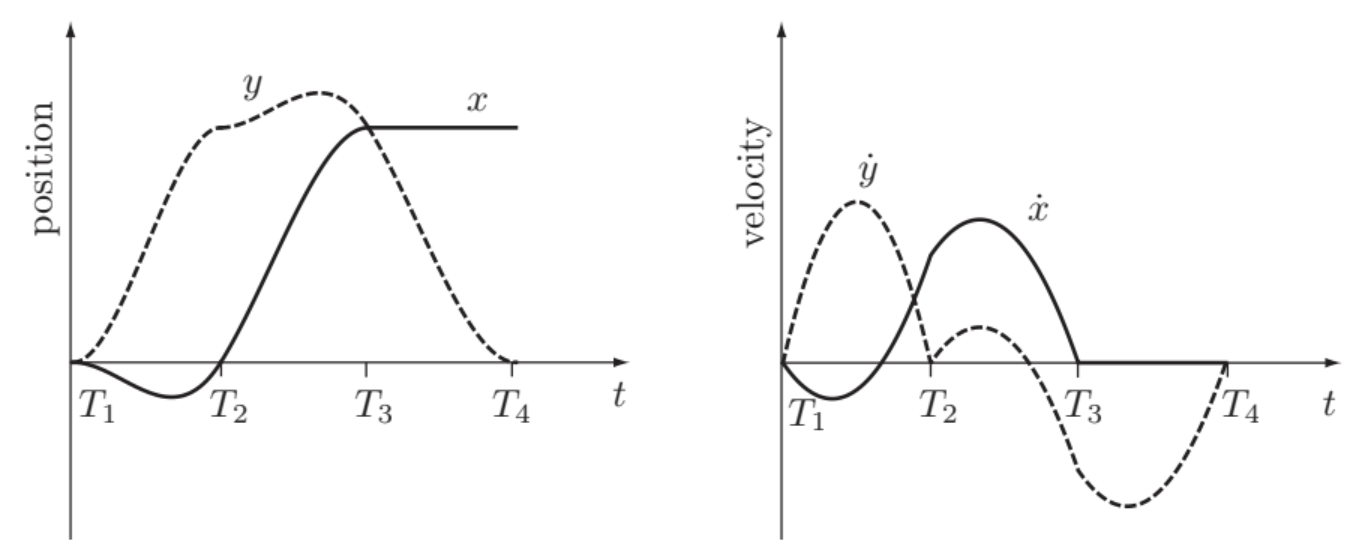

In [ ]:
x = [0, 0, 1, 1]
y = [0, 1, 1, 0]
v_x = [0, 1, 0, 0]
v_y = [0, 0, -1, 0]
t = [0, 1, 2, 3]

In [ ]:
a_x = get_interpolation_cof(t, x, v_x)
a_y = get_interpolation_cof(t, y, v_y)

Получаем

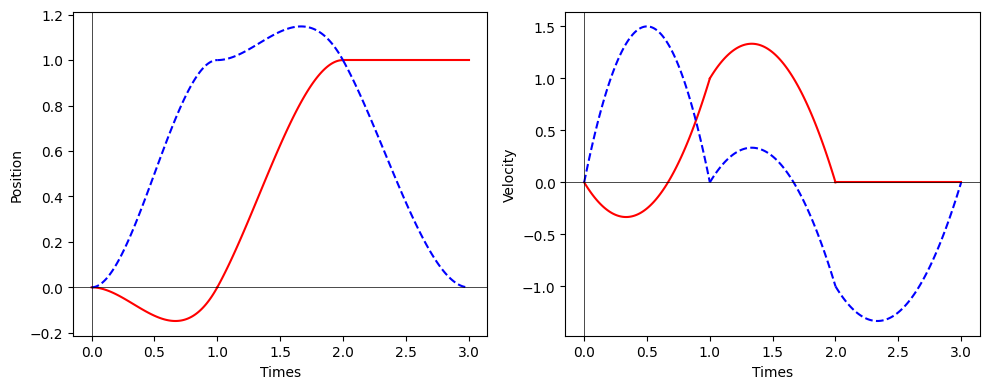

In [ ]:
plot_position_and_velocity(a_x, a_y, t)

# Интерполяция полиномом 5й степени

$a_{j2} + \Delta t a_{j3} + \Delta t^2 a_{j4} + \Delta t^2 a_{j4} = \frac{𝜷(T_{j+1}) - a_{j1} \Delta t - a_{j0}}{\Delta t^2} $

$a_{j3} + 2 \Delta t a_{j4} + 3 \Delta t^2 a_{j5} = \frac{\dot{𝜷}(T_{j+1}) - a_{j1} \Delta t - a_{j0}}{\Delta t^2} - \frac{β(T_{j+1}) - a_{j1} \Delta t - a_{j0}}{\Delta t^3} $